<a href="https://colab.research.google.com/github/Ruphai/UBS/blob/main/Point_based_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Point Analysis**

In this notebook, series of pixel-wise operations were performed to:
- Load an image
- compute image negative, 
- apply gamma correction with and without LUT (and compare their relative runtime efficiency), 
- apply the histogram equalization function, 
- compare the histeq(negative(image)) == negative(histeq(image))
- perform contrast stretch clipping the 5% extrema
- perform multi-image operators such as NDVI extraction, change detection, and conversion of RGB image to grayscale image. 


### Workspace utilities

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/


Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import img_as_float
from skimage import exposure
from skimage import io
import cv2
import time 


### Load Image

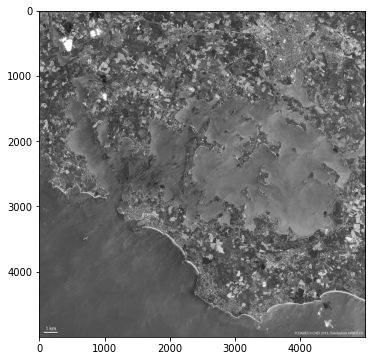

In [ ]:
# load a simple image
data = io.imread("/content/drive/MyDrive/UBS/Computer Vision/Data/em_golfe_du_morbihan_20130603.jpg")
grayscale = skimage.color.rgb2gray(data)
plt.figure(figsize = (14, 6))
plt.imshow(grayscale, cmap = "gray")
plt.show()

### Compute image negative

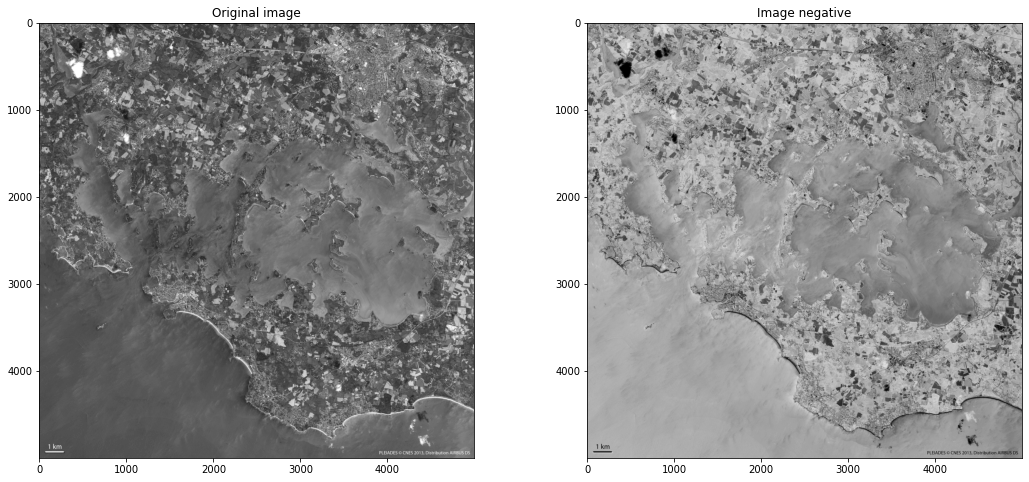

In [ ]:
def neg(img):
  """
  the image negative is obtained using by substracting each pixel intensity from
  the maximum gray level intensity in the image.
  """
  negative = 255 - img
  return negative


fig, axs = plt.subplots(1, 2, figsize = (18, 8))

axs[0].imshow(grayscale, cmap='gray')
axs[0].set_title("Original image")

axs[1].imshow(neg(grayscale), cmap ='gray')
axs[1].set_title("Image negative")
plt.show()

### Apply Gamma Correction. 
With and without a Look Up Table and report the efficiency gain.

In [ ]:
# Without LUT
# gamma correction is defined by the power law expression: Vout = A*Vin**Y, where
# A is a constant (typically taken as 1), and the input and output are 
# non-negative real values.
def gamma_corr(img, gamma):
  corrected_img = ((img/255)**(1/gamma))*255
  return corrected_img.astype(np.uint8)
  

The Execution time is:  8.215798139572144


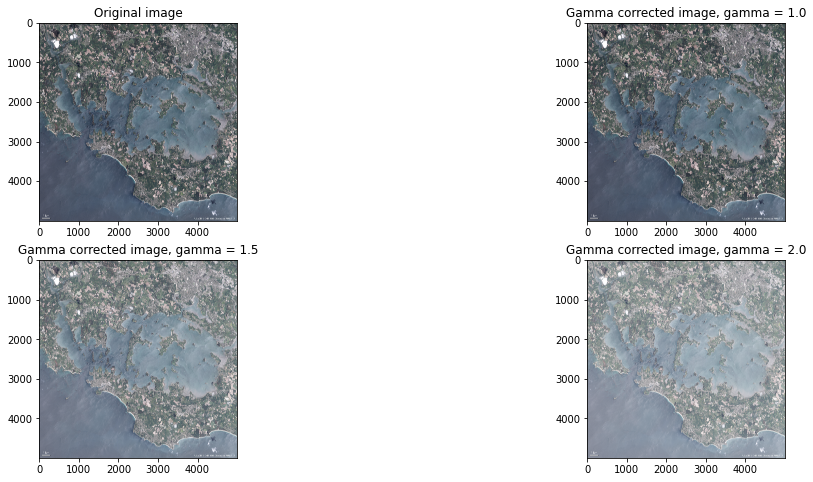

In [ ]:
start = time.time()
fig, axs = plt.subplots(2, 2, figsize = (18, 8))

axs[0, 0].imshow(data)
axs[0, 0].set_title('Original image')

axs[0, 1].imshow(gamma_corr(data, 1.0))
axs[0, 1].set_title('Gamma corrected image, gamma = 1.0')

axs[1, 0].imshow(gamma_corr(data, 1.5))
axs[1, 0].set_title('Gamma corrected image, gamma = 1.5')

axs[1, 1].imshow(gamma_corr(data, 2.0))
axs[1, 1].set_title('Gamma corrected image, gamma = 2.0')

runtime = time.time() - start
print("The Execution time is: ", runtime)

In [ ]:
# perform gamma correction with Look Up Table
def gamma_corr_LUT(img, gamma):
  "build a LUT mapping pixel values [0, 255] to gamma values"

  table = [(((i/255.0)**(1.0/gamma)) * 255) for i in np.arange(0, 256)]
  table = np.array(table, np.uint8)

  return cv2.LUT(img, table)

The Execution time is:  1.6757569313049316


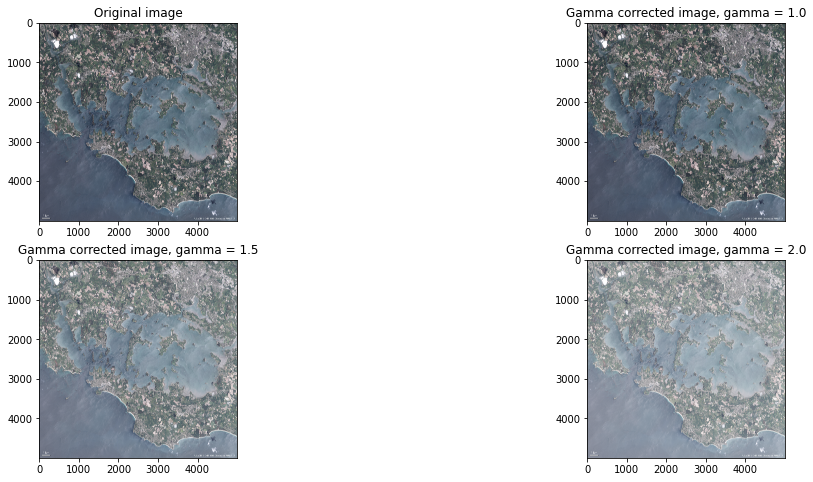

In [ ]:
start = time.time()
fig, axs = plt.subplots(2, 2, figsize = (18, 8))

axs[0, 0].imshow(data)
axs[0, 0].set_title('Original image')

axs[0, 1].imshow(gamma_corr_LUT(data, 1.0))
axs[0, 1].set_title('Gamma corrected image, gamma = 1.0')

axs[1, 0].imshow(gamma_corr_LUT(data, 1.5))
axs[1, 0].set_title('Gamma corrected image, gamma = 1.5')

axs[1, 1].imshow(gamma_corr_LUT(data, 2.0))
axs[1, 1].set_title('Gamma corrected image, gamma = 2.0')

runtime = time.time() - start
print("The Execution time is: ", runtime)

The computation of the gamma corrected images with a Look Up Table was approximately 3 times faster compared to the gamma correction without the Look Up Table. 

### The histogram equalization function
Histogram equalization enhances the contrast of an image by stretching out the most common intensity value. The main idea of histogram equalization is to increase the contrast in image areas where with low intensity so as to have an image that displays an increased number of darker and lighter areas. 



Text(0.5, 1.0, 'Cumulative image histogram')

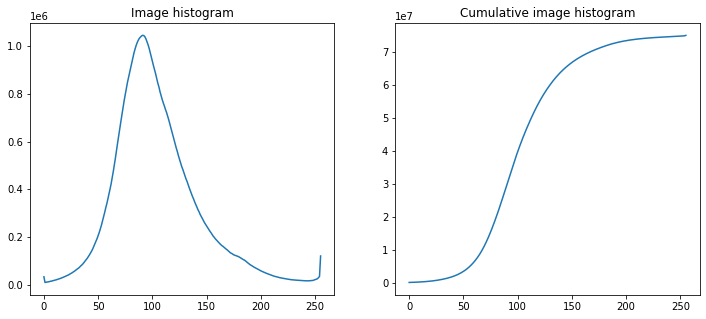

In [ ]:
# obtain a record of each intensity level
# Functions to extract the image histogram and corresponding CDF
def create_hist(img):
  "Takes a flattened image and create a histogram from it"
  hist_= np.histogram(img.flatten(), 256, range=(0, 255))[0]
  return hist_


def create_chist(hist):
  "create an array of the cumulative sum of histogram"
  return np.array([sum(hist[:i+1]) for i in range(len(hist))])

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

hist_ = create_hist(data)
axs[0].plot(hist_)
axs[0].set_title("Image histogram")

axs[1].plot(create_chist(hist_))
axs[1].set_title("Cumulative image histogram")


In [ ]:
# histogram equalization mapping
def histeq(img, number_bins=256):
  # create image histogram
  image_histogram, bins = np.histogram(img.flatten(), number_bins, density=True)
  cdf_ = create_chist(image_histogram)
  cdf = 255*cdf_/ cdf_[-1] #normalize cdf

  # the histogram equalization function
  # equalization = np.uint8(cdf_*255)

  img_equalized = np.interp(img.flatten(), bins[:-1], cdf_)

  return img_equalized.reshape(img.shape)

In [ ]:
number_bins=256
image_histogram, bins = np.histogram(grayscale.flatten(), number_bins, density=True)
bins[:-1].shape
cdf_
grayscale.flatten().shape

(24990001,)

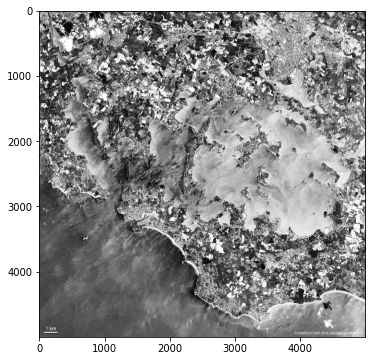

In [ ]:
img_e = histeq(grayscale)
plt.figure(figsize = (14, 6))
plt.imshow(img_e, cmap='gray')

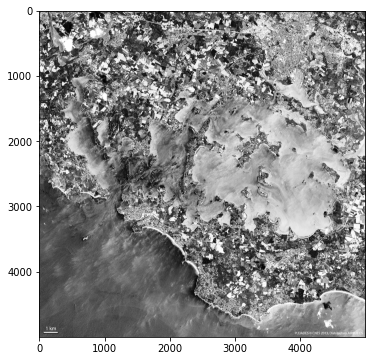

In [ ]:
# histogram equalization function from an image processing library
from skimage import exposure
img_equalized = exposure.equalize_hist(grayscale)
plt.figure(figsize = (14, 6))
plt.imshow(img_equalized, cmap='gray')

Compare the histeq(negative(image)) == negative(histeq(image))


Text(0.5, 1.0, 'Negative of Histogram Equalization')

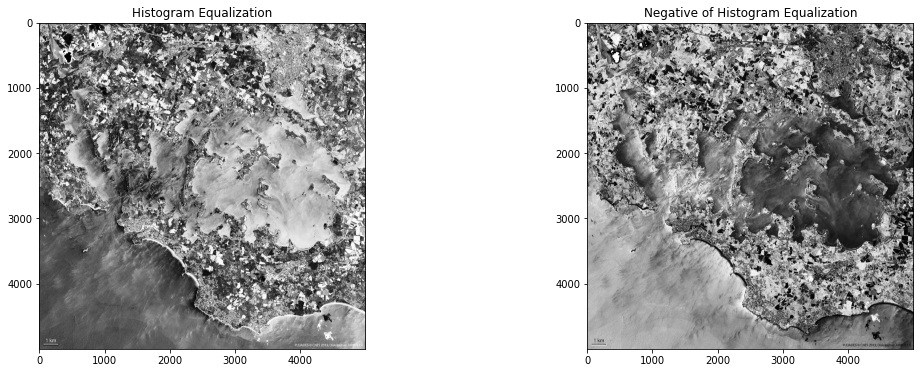

In [ ]:
#check if histeq(negative(image)) == negative(histeq(image))
# visual comparison
fig, axs = plt.subplots(1, 2, figsize = (18, 6))
axs[0].imshow(img_e, cmap = 'gray')
axs[0].set_title("Histogram Equalization")

axs[1].imshow(neg(img_e), cmap = 'gray')
axs[1].set_title("Negative of Histogram Equalization")

#(exposure.equalize_hist(neg(data))) == (neg(exposure.equalize_hist(data)))

In [ ]:
# check with direct comparison
img_e == neg(img_e)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

This shows that the negative of an image stretched by an histogram equalization method is  not the same as the histogram equalized image itself. This is shown visually and with a pixel-wise value comparison observed in the boolean display above. 

### Perform a constrast stretch clipping the 5% extrema

In [ ]:
def contrast_stretch(img):
  # Create an empty array to store the final output
  original = img.copy()
  stretched_image = np.zeros((img.shape[0], img.shape[1]), dtype = 'uint8')
  
  # Apply Min-Max Contrasting
  #clip the 5% extrema
  min, max = np.percentile(img.flatten(), [2.5, 97.5])

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      stretched_image[i,j] = 255*(grayscale[i,j]-min)/(max-min)
      
  fig, axs = plt.subplots(1, 2, figsize = (12, 6))
  
  axs[0].imshow(original, cmap = 'gray')
  axs[0].set_title("Original image")
  axs[1].imshow(stretched_image, cmap = 'gray')
  axs[1].set_title("Constrast Stretched Image")

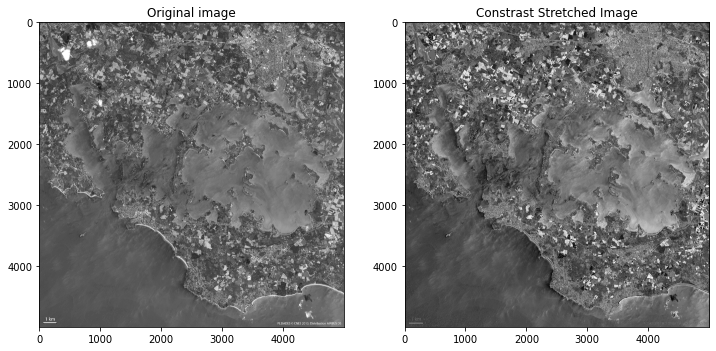

In [ ]:
contrast_stretch(grayscale)

Play with multi-image operators (e.g. NDVI extraction, change detection, RGB to gray)

Text(0.5, 1.0, 'Gray image')

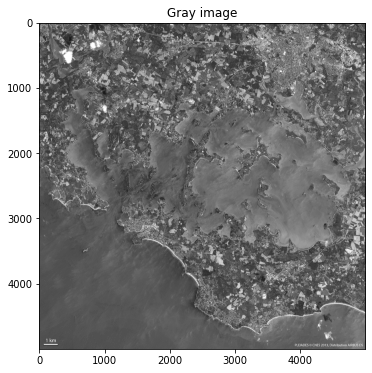

In [ ]:
#1. RGB to Gray scale

# use a pixel wise computation to transform rgb image to grayscale image

def rgb2gray_(image):
  # apply a mathematical computation for extracting gray scale information.
  gray = np.uint8(0.2989 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2])
  return gray 


gray = rgb2gray_(data)
plt.figure(figsize=(12, 6))
plt.imshow(gray, cmap="gray")
plt.title("Gray image")

In [ ]:
# import multitemporal image
ch_img = io.imread("/content/drive/MyDrive/UBS/Computer Vision/Data/qb_bmn311_subset.img")
ch_img.shape

(636, 806, 4)

In [ ]:
def ndvi_extraction(img):
  NIR = img[:, :, 3]
  Red = img[:, :, 2]
  NDVI = (NIR - Red)/(NIR + Red)
  
  fig, axs = plt.subplots(1, 2, figsize = (12, 6))
  
  axs[0].imshow(rgb2gray_(img), cmap = 'gray')
  axs[0].set_title("Original image")
  axs[1].imshow(NDVI, cmap = 'nipy_spectral')
  axs[1].set_title("NDVI Image")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


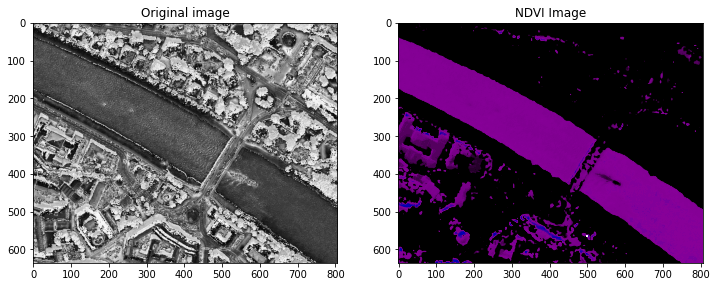

In [ ]:
ndvi_extraction(ch_img)
#ch_img[:, :, 1].shape